# Tutorial for SSVMjulia: Regression with SSVM

In [1]:
using PyPlot, SSVMjulia

The problem addressed here is presented in the slides of Dr Andrea Vedaldi, author of SVM-struct-matlab. It is a regression problem addressed with a SSVM; the basis functions chosen generate third-order polynomials

http://www.robots.ox.ac.uk/~vedaldi//assets/svm-struct-matlab/tutorial/ssvm-tutorial-handout.pdf, after slide 66.

### Problem function definitions

In [2]:
function lossCB(y, ybar)
  abs(ybar - y)
end

function featureCB(x, y)
  [y,
   y * x,
   y * x^2,
   y * x^3,
   - 0.5 * y^2]
end

function oracleCB(w, x, y)  # loss-augmented inference
  z = w[1] + w[2] * x + w[3] * x.^2 + w[4] * x.^3
    yhat = Float64[]
  if w[5] > 0
    yhat = [z - 1, z + 1] / w[5]
    yhat = max(min(yhat, 1),-1)
  end
    append!(yhat, [-1, 1])   
    augLoss = y_::Vector{Float64} -> abs(y_ - y) + z * y_ - 0.5 * y_.^2 * w[5]
  worse = indmax(augLoss(yhat))
    yhat = yhat[worse]
end

function oracleCB(w, x)    # inference
    z = w[1] + w[2] * x + w[3] * x.^2 + w[4] * x.^3
    y = z / w[5]
end

oracleCB (generic function with 2 methods)

### Data generation

In [3]:
x = collect(linspace(-pi,pi,21))
y = 0.5*sin(x)
y = y + 0.1*randn(size(y));
y_test = y + 0.1*randn(size(y));
xr = collect(linspace(minimum(x), maximum(x), 1024))
yr = collect(linspace(-1,1,1024));

### SVM-struct-julia parameters

See the next two dictionaries for help on the options:

In [4]:
SSVMjulia.helpparam

Dict{Symbol,ASCIIString} with 8 entries:
  :c               => "SSVM regularization weight"
  :oracleFn        => "Oracle function"
  :X               => "Vector of training patterns"
  :featureFn       => "Joint feature function"
  :positivity_zero => "minimum value of w considered as 0."
  :lossFn          => "Loss function"
  :Y               => "Vector of training labels"
  :positivity      => "index of additional positivity constraints in w, defaut …

In [5]:
SSVMjulia.helpoptions

Dict{Symbol,ASCIIString} with 12 entries:
  :num_passes    => "Number of iterations, default 200"
  :Ytest         => "Y_test list"
  :max_time      => "Maximum running time in minutes, default Inf"
  :cachesize     => "Size of cache per training example, default 10; can be 0 o…
  :incremental   => "[10., 50.] will reduce the training set\nto 10% in the fir…
  :Xtest         => "X_test list"
  :mincachesize  => "Minimum size of the cache before we start using it, defaul…
  :verbose       => "verbosity, default 1"
  :w0            => "initial w (defaults to zeros)"
  :quadratic     => "Quadratic optimization algorithm\neither :pegasos (default…
  :eps           => "Constraint tolerance, default 0.1"
  :test_interval => "Do the testing every ... iterations."

**in this example we will use the following options:**

In [6]:
param = Dict(
:X => x,
:Y => y,
:featureFn => featureCB,
:lossFn => lossCB,
:oracleFn => oracleCB,
:c => 1,
# :positivity => [3],  # to enforce a positivity constraint on a coordinate of w
)

options = Dict(
:quadratic => :primalqp,
:eps => 0.001,
:num_passes => 200,
:cachesize => 10,
# :incremental => [50., 80.], # to increase training set size in subsequent steps
:Xtest => x,
:Ytest => y_test,
:verbose => 4,
:w0 => 0.01 * ones(5)
);

### Running the SSVM

In [7]:
helper[:test_loss]

LoadError: LoadError: UndefVarError: helper not defined
while loading In[7], in expression starting on line 1

In [8]:
helper = Dict()
w = ssvm1slack(param, options, helper);

[SSCM1slack] initializing Convex.jl problem
[SSCM1slack] begin learning...
[SSCM1slack] Testing test set... done! mean test loss: 10.51090889509328
[SSCM1slack] Iter 1: launching inference round (21/21 samples)...
[SSCM1slack] New violation 1

            (Perhaps this is the first time you're solving this problem?)
            Warmstart may be ineffective.


.2874048150176323
[SSCM1slack] Solving quadratic problem... done! primal: 0.40887865275284374.
[SSCM1slack] Testing test set... done! mean test loss: 17.397542204718693
[SSCM1slack] Iter 2: launching inference round (21/21 samples)...
[SSCM1slack] New violation 6.621082674175447
[SSCM1slack] Solving quadratic problem... done! primal: 0.6620513826532602.
[SSCM1slack] Testing test set... done! mean test loss: 4.820197656308646
[SSCM1slack] Iter 3 cache violation 1.1040125127789453: using cache...
[SSCM1slack] Solving quadratic problem... done! primal: 0.8016769436685366.
[SSCM1slack] Testing test set... done! mean test loss: 2.9524998650014984
[SSCM1slack] Iter 4 cache violation 0.030912369806255065: using cache...
[SSCM1slack] Solving quadratic problem... done! primal: 0.8179466405469883.
[SSCM1slack] Testing test set... done! mean test loss: 3.048987949304833
[SSCM1slack] Iter 5 cache violation 0.024100738145068: using cache...
[SSCM1slack] Solving quadratic problem... done! primal: 0.

helper contains information about the optimization process:

In [9]:
print(helper[:iterations], " iterations; ", helper[:inferences], " augmented inferences")

### Results

In [10]:
w

5-element Array{Float64,1}:
 -0.0179684 
  0.948754  
 -0.00106629
 -0.10116   
  2.0298    

In [11]:
z = w[1] + w[2] * xr + w[3] * xr.^2 + w[4] * xr.^3;
F = yr*z' - 0.5 * yr.^2 * ones(size(z))' * w[5]; # scoring function
F_ = F .- maximum(F, 1); # column rescaled
y_fit = oracleCB(w, xr);

[SSCM1slack] Testing test set... done! mean test loss: 0.1205654888228518
[SSCM1slack] Iter 77 cache violation 0.0008832932161271789: launching inference round (21/21 samples)...
[SSCM1slack] New violation 0.001574678167062249
[SSCM1slack] Solving quadratic problem... done! primal: 9.335417264433044.
[SSCM1slack] Testing test set... done! mean test loss: 0.12092223508985724
[SSCM1slack] Iter 78 cache violation 0.0006931147408333893: launching inference round (21/21 samples)...
[SSCM1slack] New violation 0.0008187722971419453
[SSCM1slack] Finished (converged)!
78 iterations; 189 augmented inferences

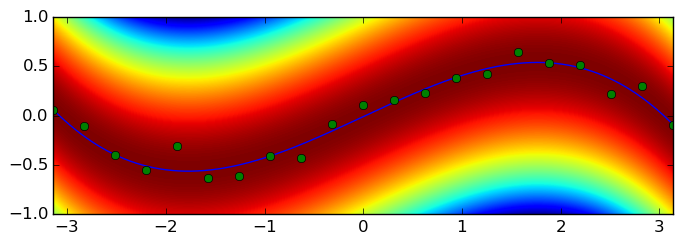

In [12]:
imshow(F_, extent=[minimum(x), maximum(x), -1, 1], origin="lower")
plot(xr, y_fit)
plot(x, y, "o")
xlim([minimum(x), maximum(x)]);

### Loss on the test set

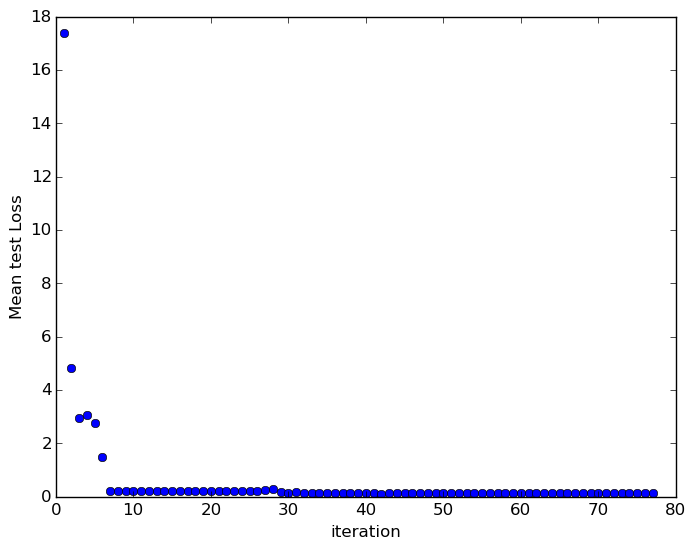

In [13]:
plot(helper[:test_iter][2:end], helper[:test_loss][2:end], "o")
xlabel("iteration")
ylabel("Mean test Loss");

### Time spent for solving the quadratic subproblems (uses warmstarting)

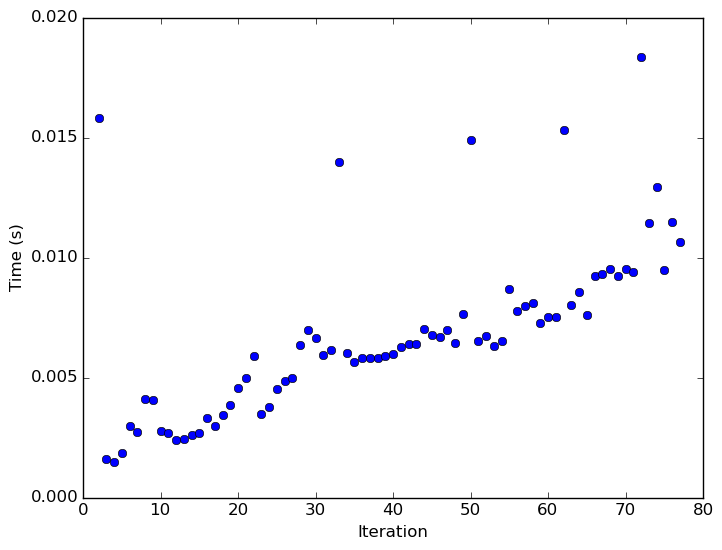

In [14]:
plot(2:helper[:iterations]-1, helper[:time_quadratic][2:end], "o") # first iteration is much longer, no warm-start
xlabel("Iteration")
ylabel("Time (s)");

### SSVM primal objective

In [16]:
helper

Dict{Any,Any} with 13 entries:
  :time_quadratic   => [4.8809,0.0158279,0.00159216,0.00148082,0.00185108,0.002…
  :inferences       => 189
  :inference_rounds => 9
  :total_time       => 6.517595052719116
  :test_iter        => [0,1,2,3,4,5,6,7,8,9  …  68,69,70,71,72,73,74,75,76,77]
  :time_inference   => [0.2608978748321533,0.00020194053649902344,0.00020909309…
  :iterations       => 78
  :violation        => [1.2874,6.62108,1.10401,0.0309124,0.0241007,1.60063,1.74…
  :test_loss        => [10.5109,17.3975,4.8202,2.9525,3.04899,2.76442,1.49685,0…
  :inference_iter   => [1,2,6,27,48,63,74,77,78]
  :xi               => [1.76349e-6,-2.06169e-6,-1.93378e-6,2.69344e-6,-3.6077e-…
  :primal           => [0.408879,0.662051,0.801677,0.817947,0.832939,1.31658,2.…
  :w_serie          => [[0.01,0.01,0.01,0.01,0.01],[-0.03204325411707318,0.4952…

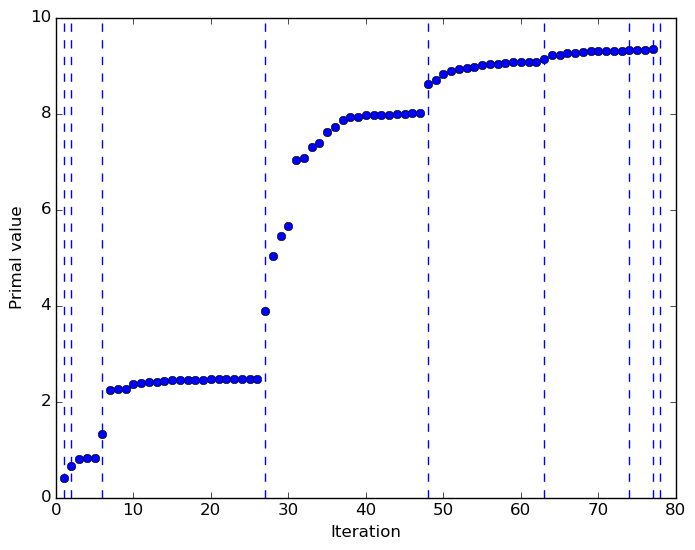

In [17]:
plot(1:helper[:iterations]-1, helper[:primal], "o")
for i in helper[:inference_iter]
    axvline(x=i, ls="--")
end
xlabel("Iteration")
ylabel("Primal value");

The vertical dashed lines represent the iterations where a full round of inference is done. The other iterations use constraint caching. **One can see jumps in the primal objective where the cached constraints have been exhausted and the algorithm resorts to a new full inference.**

### Comments

The current implementation solves the QP primal suproblem, making it easy to add new primal constraints, such as positivity constraints. The SSVM dual does not get computed; doing so could add a certificate of optimality in future improvements.

Current implementation has the following advantages over SVM-struct-matlab:
* Constraint caching (reuse full inference results)
* Parallellization of the inference step (one process per example)
* Additional positivity constraints on arbitrary coordinates of $w$

The two first points are very beneficial in settings were the inference task takes most of the time.

### Possible improvements

* Constraint deletion (deletion of old unused constraints)
* Dual computation (to get optimality certificates)
* Compare performance of QP solvers